In [1]:
from importlib.metadata import version

import tiktoken
import torch 

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.1.2
tiktoken version: 0.6.0


In [4]:
import os
import requests

pdf_path = "constitution-of-india.pdf"

if not os.path.exists(pdf_path):
    print("File doesnt exist")
else:
    print(f"file {pdf_path} exists.")

file constitution-of-india.pdf exists.


In [5]:
#PDF to text  1. PyMuPDF  2. fitz
import pymupdf #pdf -> text 


def OpenAndReadPdf(pdf_path):
    """
    Opens a pdf file , reads its text content page by page, and collects statistics.

    Params: 
        pdf_path(str): The file path to the PDF documents to be opened and read.

    Returns:
        list[dict] : A list of dictionaries, each containing the page number (adjusted),
        character count, word count, sentence count, token count, and the extracted text for each page
    """
    doc = pymupdf.open(pdf_path)
    pages_and_texts = []
    for page_number, page in enumerate(doc):
        text = page.get_text()
        text = text.replace("\n", " ")
        pages_and_texts.append({"page_number": page_number - 30, 
                                "page_char_count": len(text),
                                #"page_word_count": len(text).split(" "),
                                "page_Sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text)/4 , #1token = ~4 chars
                                "text":text})

        return pages_and_texts

    
pages_and_texts = OpenAndReadPdf(pdf_path=pdf_path)
pages_and_texts[:2]

[{'page_number': -30,
  'page_char_count': 188,
  'page_Sentence_count_raw': 1,
  'page_token_count': 47.0,
  'text': '£ÉÉ®iÉ BÉEÉ ºÉÆÉÊ´ÉvÉÉxÉ  [1 , 2024 ] THE CONSTITUTION OF INDIA [As on 1st May, 2024]  2024 GOVERNMENT OF INDIA MINISTRY OF LAW AND JUSTICE LEGISLATIVE DEPARTMENT, OFFICIAL LANGUAGES WING '}]

In [6]:
doc = pymupdf.open(pdf_path)
raw_text = ""
for page in doc:
    raw_text += page.get_text()
    #print(text)

In [53]:
len(doc)

402

In [7]:
f= open("constitution-of-india.txt", "a")
f.write(raw_text)
f.close()

In [8]:
with open(r".\constitution-of-india.txt", 'r', encoding='utf-8') as f:
    raw_text = f.read()

In [9]:
print('no of characters:', len(raw_text))
print(raw_text[55:99])

no of characters: 1740383
E CONSTITUTION
C.O. 273
In exercise of the p


In [10]:
type(raw_text)

str

## **Sample text for tokenizer**

In [11]:
import re 
text = "hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [12]:
result = re.split(r'([,.]|\s)', text)
print(result)

['hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [13]:
result = [items for items in result if items.strip()]
print(result)

['hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [14]:
text = 'The Constitution (One Hundredth Amendment) Act, 2015'

result = re.split(r'([,.;:"()\'_!?]|--|\s)', text)
result = [item for item in result if item.split()]
print(result)

['The', 'Constitution', '(', 'One', 'Hundredth', 'Amendment', ')', 'Act', ',', '2015']


## **Preprocessing**

In [15]:
preprocessed = re.split(r'([,.?:;"()\'_!]|--|\s)', raw_text)
preprocessed = [item for item in preprocessed if item.split()]
print(preprocessed[:30])

['371', 'APPENDIX', 'III', '1DECLRATION', 'UNDER', 'ARTICLE', '370', '(', '3', ')', 'OF', 'THE', 'CONSTITUTION', 'C', '.', 'O', '.', '273', 'In', 'exercise', 'of', 'the', 'powers', 'conferred', 'by', 'clause', '(', '3', ')', 'of']


In [16]:
print(len(preprocessed))

381073


### Convert tokens into token IDs

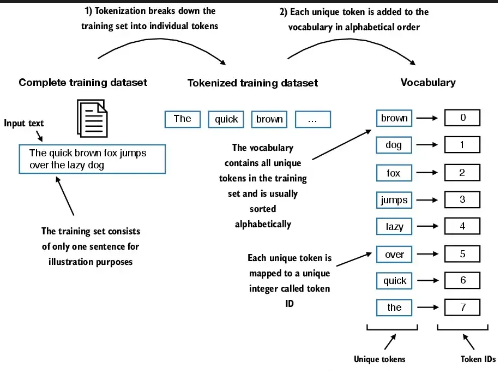

In [17]:
#from the preprocessed text, we can now build a vocabulary that consists of all the unique tokens

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
print(vocab_size)

6812


In [26]:
vocab = {token:integer for integer, token in enumerate(all_words)}

In [19]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('"', 0)
('&', 1)
("'", 2)
('(', 3)
(')', 4)
('*', 5)
('**', 6)
('****', 7)
('**Entry', 8)
('*11', 9)
('*7', 10)
('*Now', 11)
('*Puducherry', 12)
('*Sadar-I-Riyasat', 13)
('*]', 14)
('*]]', 15)
('*four', 16)
(',', 17)
('-', 18)
('.', 19)
('/', 20)
('0', 21)
('000', 22)
('01', 23)
('02', 24)
('03-01-1977', 25)
('04', 26)
('05', 27)
('07', 28)
('09', 29)
('1', 30)
('1*', 31)
('1***', 32)
('1***]', 33)
('1-1-2004', 34)
('1-1-2007', 35)
('1-1-2016', 36)
('1-10-1959', 37)
('1-10-1968', 38)
('1-10-2006', 39)
('1-10-2013', 40)
('1-11-', 41)
('1-11-1956', 42)
('1-11-1966', 43)
('1-11-1973', 44)
('1-11-1986', 45)
('1-11-2000', 46)
('1-11-2011', 47)
('1-12-1963', 48)
('1-2-1977', 49)
('1-2-1992', 50)


### Sample text - Tokenizing - Vocab - Token ID

In [20]:
class SimpleTokenizerV1:

    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

* The `encode` function turns text into token IDs
* the `decode` function turns token IDs back to text

In [21]:
tokenizer = SimpleTokenizerV1(vocab)

text = """The Constitution (One Hundredth Amendment) Act, 2015 
            containing details of acquired and transferred territories 
            between the Governments of India and Bangladesh has been 
            provided in Appendix I."""

ids = tokenizer.encode(text)
print(ids)

[2924, 1728, 3, 2485, 2086, 1467, 4, 1426, 17, 572, 3830, 4022, 5202, 3202, 3351, 6310, 6208, 3534, 6222, 2036, 5202, 2127, 3351, 1549, 4572, 3516, 5563, 4662, 1490, 2090, 19]


In [22]:
tokenizer.decode(ids)

'The Constitution( One Hundredth Amendment) Act, 2015 containing details of acquired and transferred territories between the Governments of India and Bangladesh has been provided in Appendix I.'

### Adding special context tokens

- add some "special tokens for unknown words and to denote the end of a text
- [BOS] - Beginning of Sequence
- [EOS] - End of Sequence - used to concatenate multiple unrelated texts.
- [PAD] - Padding - we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have equal lengths
- [UNK] - rep works that are not included in the vocab
- 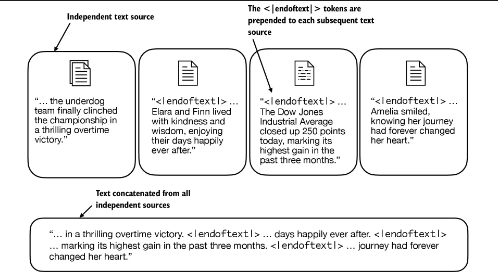

In [23]:
tokenizer = SimpleTokenizerV1(vocab)
text = "Hello, do you like tea, Is this-- a test?"

tokenizer.encode(text)

KeyError: 'Hello'

In [29]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])


vocab = {token:integer for integer, token in enumerate(all_tokens)}


In [30]:
len(vocab.items())

6814

In [32]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('…', 6809)
('……', 6810)
('………', 6811)
('<|endoftext|>', 6812)
('<|unk|>', 6813)


In [33]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self,text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [ item if item in self.str_to_int
                         else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [34]:
tokenizer = SimpleTokenizerV2(vocab)
text1 = "Hello, do you like Coffee?"
text2 = "Would you like to join for lunch."

text = "<|endoftext|>".join((text1, text2))

print(text)

Hello, do you like Coffee?<|endoftext|>Would you like to join for lunch.


In [35]:
tokenizer.encode(text)

[6813,
 17,
 4123,
 6813,
 4916,
 6813,
 6813,
 6813,
 6813,
 4916,
 6280,
 6813,
 4442,
 6813,
 19]

In [36]:
tokenizer.decode(tokenizer.encode(text))


'<|unk|>, do <|unk|> like <|unk|> <|unk|> <|unk|> <|unk|> like to <|unk|> for <|unk|>.'

### **BytePain Encoding**

- GPT-2 used BytePair encoding as tokenizer.
- https://github.com/openai/gpt-2/blob/master/src/encoder.py


In [11]:
import importlib.metadata as importlib_metadata
import tiktoken

print("tiktoken version:", importlib_metadata.version("tiktoken"))

tiktoken version: 0.6.0


In [12]:
tokenizer = tiktoken.get_encoding("gpt2")

In [13]:
text = (
    "Hello, do you like Coffee? <|endoftext|>"
    "Would you like to join for lunch."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 19443, 30, 220, 50256, 17353, 345, 588, 284, 4654, 329, 9965, 13]


In [8]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like Coffee? <|endoftext|>Would you like to join for lunch.


- BPE tokenizer breakdown unknown words into subwords and individual characters:
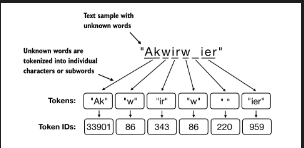

### **Data sampling with a sliding window**

- We train LLMs to generate one word at a time.
- So we want to prepare the training data accordingly.
- Next word in a sequence represents the target to predict.
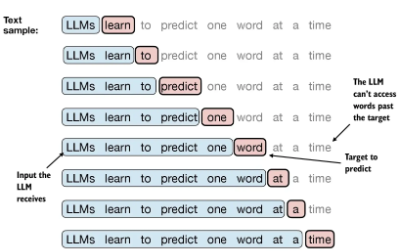

In [14]:
with open("constitution-of-india.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(len(enc_text))

466001


- For each text chunck, we want the inputs and targets.
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [19]:
enc_sample = enc_text[59:]

In [20]:
context_size = 4

In [21]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "------->", desired)

[286] -------> 3794
[286, 3794] -------> 11
[286, 3794, 11] -------> 262
[286, 3794, 11, 262] -------> 1992


In [22]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "------->", tokenizer.decode([desired]))

 of ------->  India
 of India -------> ,
 of India, ------->  the
 of India, the ------->  President


- We implement a simple data loader that iterates over the input dataset and reforms the inputs and targets shifted by one

In [23]:
import torch 
print("PyTorch_version:", torch.__version__)

PyTorch_version: 2.1.2+cpu


In [19]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids= []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        for i in range(0,len(token_ids) - max_length, stride):
            input_chunk = token_ids[ i   : i + max_length     ]
            target_chunk= token_ids[ i+1 : i + max_length + 1 ]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self,idx):
        return self.input_ids[idx], self.target_ids[idx]

In [17]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride = 128, shuffle = True, drop_last= True, num_workers=0  ):

    tokenizer = tiktoken.get_encoding("gpt2")

    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    dataloader = DataLoader( dataset, batch_size=batch_size,shuffle = shuffle,
                             drop_last=drop_last, num_workers=num_workers)
    return dataloader


In [26]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride = 1, shuffle = False
)
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[38056,   198, 24805, 10619]]), tensor([[  198, 24805, 10619, 10426]])]


In [27]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[  198, 24805, 10619, 10426]]), tensor([[24805, 10619, 10426,  6711]])]


In [29]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle= False)

data_iter = iter(dataloader)
inputs, targets= next(data_iter)

print("input:\n",inputs)
print("targets:", targets)

input:
 tensor([[38056,   198, 24805, 10619],
        [10426,  6711,   198,    16],
        [41374, 35972,  6234, 35219],
        [48301, 28687,     7,    18],
        [    8,  3963,  3336,  7102],
        [ 2257,  2043, 35354,   198],
        [   34,    13,    46,    13],
        [38549,   198,   818,  5517]])
targets: tensor([[  198, 24805, 10619, 10426],
        [ 6711,   198,    16, 41374],
        [35972,  6234, 35219, 48301],
        [28687,     7,    18,     8],
        [ 3963,  3336,  7102,  2257],
        [ 2043, 35354,   198,    34],
        [   13,    46,    13, 38549],
        [  198,   818,  5517,   286]])


### **Create token embeddings**

- Data is already almost ready for an LLM.
- embed the tokens in a continous vector representation using an embedding layer.
- Usually, these embedding layers are part of the LLM itself and are updated during model training.

In [2]:
#suppose we have the following four inputs with input ids 1, 2, 3, 5 (after tokenization):
import torch
input_ids = torch.tensor([1, 2, 3, 5])

In [4]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)

embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [6]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [7]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [8]:
print(embedding_layer(input_ids))

tensor([[ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096]], grad_fn=<EmbeddingBackward0>)


#### An embedding layer is essentially a look-up operation
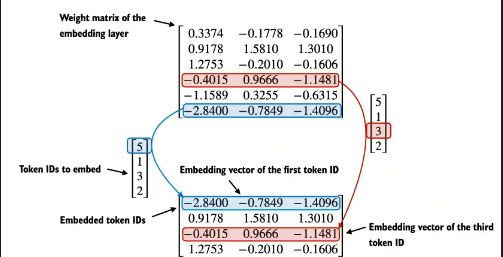
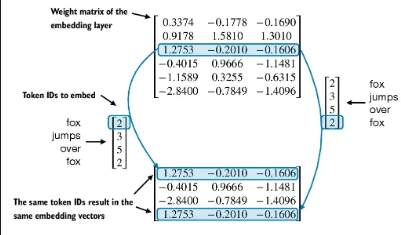

- Positional embedding are combined with the token embedding vector to form the input embedding for a large language model
- 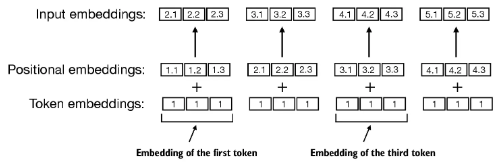

- BytePair encoder - vocab size - 50257

In [9]:
#Suppose we want to encode the input tokens into 256-dimensional vector rep

vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [20]:
max_length = 4
dataloader= create_dataloader_v1(
    raw_text, batch_size=8, max_length= 4,
    stride =max_length, shuffle = False
)

data_iter = iter(dataloader)
inputs,targets = next(data_iter)

In [22]:
print("TokenIDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)
print("Target:\n", targets)

TokenIDs:
 tensor([[38056,   198, 24805, 10619],
        [10426,  6711,   198,    16],
        [41374, 35972,  6234, 35219],
        [48301, 28687,     7,    18],
        [    8,  3963,  3336,  7102],
        [ 2257,  2043, 35354,   198],
        [   34,    13,    46,    13],
        [38549,   198,   818,  5517]])

Inputs shape:
 torch.Size([8, 4])
Target:
 tensor([[  198, 24805, 10619, 10426],
        [ 6711,   198,    16, 41374],
        [35972,  6234, 35219, 48301],
        [28687,     7,    18,     8],
        [ 3963,  3336,  7102,  2257],
        [ 2043, 35354,   198,    34],
        [   13,    46,    13, 38549],
        [  198,   818,  5517,   286]])


In [23]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [24]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [26]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [27]:
input_embeddings =  token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
